# Training a NN: Backpropagation

## Introduction

In [2]:
# imports
import numpy as np
import os
import pandas as pd
import sklearn

import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

As an example for this chapter, let's again load the MNIST fashion dataset. 
To use it in a NN, we scale the pixel intensities to mean 0 and standard deviation 1

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

Suppose we have the following NN to make predictions:

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

/Users/korbinianziegltrum/miniconda3/envs/ml2/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The Fitting Process is simply Gradient Descent. But it is rather complicated for NN, since they are layers upon layers of functions. Differentiation works with chain rule, and means multiplying at least one Jacobian Matrix per Layer! If you multiply many matrices, it's like multiplying many numbers: if all numbers are small, the result will almost vanish; if all numbers are big, the result will explode. 

**Frequent problems:** 
- Vanishing gradient $\rightarrow$ optimization progress stops without solution
- Exploding gradient $\rightarrow$ optimization just "jumps around" randomly
- Gradients are ok, but convergence still too slow or stuck zig-zagging
These problems get more difficult and frequent the deeper the NN is. But: deeper NNs are more powerful! 

Another problem: The loss functions of NNs are NOT convex! Therefore there is not just one global minimum, and the solution depends on the initialization. But: usually the solution ends up near a global optimum. 

$\Rightarrow$ **Fact:** Optimizing NNs is a very delicate business. Many things can go wrong. 

**Questions we will answer:**
- how to make deep learning possible
- which activation functions are "good" ones for optimization
- learn better optimizers for NNs
- learn "good" heuristics for choosing the learning rate

First of all, let's repeat how learning works for most ML models, including all necessary mathematical background, step by step. 

## Gradient Descent Revisited

### Mathematical Background 

$\rightarrow$ See Jupyter Notebook on mathematical background and/or the provided videos. 

### Gradient Descent 

**Question:** Given a smooth real-valued functions $f(x_1,\ldots, x_n)$ in $n$ variables (n-dimensional input, one-dimensional output), what does the graph of the function look like?

**Answer:** a hypersurface in $n+1$-dimensional space, like a surface in 3D, with hills and valleys. 

### Example: 1D linear regression loss function

<br></br><img src="../assets/Image_Lin_Reg_Fit.jpg" alt="Lin_Reg_Fit" width="300" title = "UDL"/>   <br></br>

prediction function: $h(x)=\theta_0+\theta_1\cdot x$ $\Rightarrow$ MSE is a real-valued function in two variables $\theta_0, \theta_1$. 

**Question:** What is the graph of $h$ in geometric terms?


Answer: A smooth surface in 3D-space. 
<br></br><img src="../assets/Image_1D_Lin_Reg_Loss_fct.png" alt="Lin_Reg_Loss_Fct" width="500" title = "UDL"/>   <br></br>


Gradient descent: 
Start at a random point $(\theta_0^0, \theta_1^0)$, denoted 0 below. This point corresponds to two initial values for the parameters $\theta_0$ and $\theta_1$ (this model is still far off): 
<br></br><img src="../assets/Image_Lin_Reg_Opt_First_Step.png" alt="Image_Lin_Reg_Opt_First_Step" width="500" title = "UDL"/>   <br></br>

Compute the negative gradient $-\nabla f(\theta_0^0, \theta_0^1)$ at this point = 2d-vector = direction of steepest descent. 
Go one step in this direction (size of step is determined by $eta$, the learning rate): $$(\theta_0^1, \theta_1^1):= (\theta_0^0, \theta_1^0) -\eta\cdot \nabla f(\theta_0^0, \theta_1^0).$$ 

These new parameters $(\theta_0^1, \theta_1^1)$ give us a new model: 
<br></br><img src="../assets/Image_Lin_Reg_Opt_Second_Step.png" alt="Image_Lin_Reg_Opt_Second_Step" width="500" title = "UDL"/>   <br></br>

Again, we compute the gradient at this point ... and take another step 
<br></br><img src="../assets/Image_Lin_Reg_Opt_Third_Step.png" alt="Image_Lin_Reg_Opt_Third_Step" width="500" title = "UDL"/>   <br></br>

And again: 
<br></br><img src="../assets/Image_Lin_Reg_Opt_Fourth_Step.png" alt="Image_Lin_Reg_Opt_Fourth_Step.png" width="500" title = "UDL"/>   <br></br>

... until we get to the minimum 
<br></br><img src="../assets/Image_Lin_Reg_Opt_Fifth_Step.png" alt="Image_Lin_Reg_Opt_Fifth_Step.png" width="500" title = "UDL"/>   <br></br>

General Algorithm for the optimization of a function $f(x_1,\ldots, x_n)$:
- Start at a random point $(x_1^0,\ldots, x_n^0)$ 
- ith step: 
    - compute $-\nabla f(x_1^{i-1},\ldots, x_n^{i-1})$; 
    - update: $(x_1^{i},\ldots, x_n^{i}):= (x_1^{i-1},\ldots, x_n^{i-1})-\eta_i\cdot \nabla f(x_1^{i-1},\ldots, x_n^{i-1})$
    - here, $\eta_i$ is the learning rate for step i. (has to be chosen)
- repeat until convergence to a (local) minimum. 

#### Problems with GD

- GD might get stuck in a local minimum. 
- In a large NN, there are thousands up to millions of parameters to be trained $\Rightarrow$ GD is too slow

$\Rightarrow$ Use SGD for NNs: 
- due to its stochastic nature (zig-zagging around just a little) it can "jump out" of local minima
- MUCH faster. 
- works as a regularizer, so a model trained with SGD usually generalizes better. 

## Stochastic Gradient Descent

In ML, we optimize a loss which is a **sum/average over the losses for all instances** : 
$$L_D(\theta)=\frac{1}{m}\sum_{i=1}^m L_{(\mathbf{x}^{(i)},y^{(i)})}(\theta)$$
$\Rightarrow$ Can be millions of summands for each step!

**Idea:** At each step, don't take all samples, but only one randomly picked sample (or a few = **mini-batch**) to speed things up! 

**Stochastic Gradient Descent:** Instead of taking 
$\nabla L_D(\theta)=\frac{1}{m}\sum_{i=1}^m \nabla L_{(\mathbf{x}^{(i)},y^{(i)})}(\theta)$ as the update at each gradient descent step, 
only take 
$\nabla L_{B}(\theta)=\frac{1}{\sharp B}\sum_{i\in B} \nabla L_{(\mathbf{x}^{(i)},y^{(i)})}(\theta)$ for a random mini-batch $B\subset D$. B could only consist of one example. 

Problem: Which training samples are chosen in which order does have an impact on the optimization process! $\Rightarrow$ go through your training set not only once, but many times in different orders, and learning continues! 

Going through all training data once is called an **epoch**. Shuffle data after each epoch! 

**Mini-batch learning:** SGD with a few instances $B$=**mini-batch** at each gradient step. After each epoch, shuffle data and divide into new mini-batches. 

**Good practice for SGD:** how many samples in a mini-batch? $\rightarrow$ trial & error. Usually between 32 and 256 samples. 


Let's look at the code for Gradient Descent (also called Batch or Full-Batch Gradient Descent) vs. SGD in an example: 

In [5]:
# Setting up a linear regression example
m = 100
X = 2*np.random.rand(m, 1)
X_b = np.c_[np.ones((m, 1)), X]
y = 4 + 3*X + np.random.rand(m, 1)

def learning_schedule(t, t0, t1):
    return t0/(t+t1)

In [6]:
def batch_gradient_descent():
    n_iterations = 1000
    learning_rate = 0.05
    thetas = np.random.randn(2, 1)
    thetas_path = [thetas]
    for i in range(n_iterations):
        gradients = 2*X_b.T.dot(X_b.dot(thetas) - y)/m
        thetas = thetas - learning_rate*gradients
        thetas_path.append(thetas)

    return thetas_path

In [7]:
def stochastic_gradient_descent():
    n_epochs = 50
    t0, t1 = 5, 50
    thetas = np.random.randn(2, 1)
    thetas_path = [thetas]
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_b[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2*xi.T.dot(xi.dot(thetas) - yi)
            eta = learning_schedule(epoch*m + i, t0, t1)
            thetas = thetas - eta*gradients
            thetas_path.append(thetas)

    return thetas_path

In [8]:
def mini_batch_gradient_descent():
    n_iterations = 50
    minibatch_size = 20
    t0, t1 = 200, 1000
    thetas = np.random.randn(2, 1)
    thetas_path = [thetas]
    t = 0
    for epoch in range(n_iterations):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_b[shuffled_indices]
        y_shuffled = y[shuffled_indices]
        for i in range(0, m, minibatch_size):
            t += 1
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2*xi.T.dot(xi.dot(thetas) - yi)/minibatch_size
            eta = learning_schedule(t, t0, t1)
            thetas = thetas - eta*gradients
            thetas_path.append(thetas)

    return thetas_path

In [9]:
bgd_thetas = np.array(batch_gradient_descent())
sgd_thetas = np.array(stochastic_gradient_descent())
mbgd_thetas = np.array(mini_batch_gradient_descent())

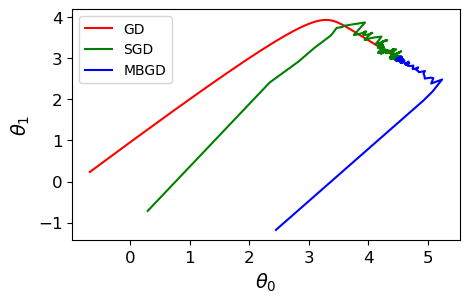

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(bgd_thetas[:,0], bgd_thetas[:,1], "r-", label='GD')
plt.plot(sgd_thetas[:,0], sgd_thetas[:,1], "g-", label='SGD')
plt.plot(mbgd_thetas[:,0], mbgd_thetas[:,1], "b-", label='MBGD')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend()

plt.show()
